In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
'''
All the Functions
'''
def calculate_1d_anom(var):
    var_raw = var.mean(['lat', 'lon'])
    var_clim = var_raw.groupby("time.month").mean(dim="time")
    var_anom = var_raw.groupby("time.month") - var_clim
    return var_anom

def calculate_anom(var):
    var_clim = var.groupby("time.month").mean(dim="time")
    var_anom = var.groupby("time.month") - var_clim
    return var_anom

# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [4]:
# --- read data ---
idir = '/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/'
pr1Name = 'r1i1p2f1/Amon/pr/gn/v20230616/pr_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-059912.nc'
u1Name = 'r1i1p2f1/Amon/ua/gn/v20230616/ua_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-059912.nc'
v1Name = 'r1i1p2f1/Amon/va/gn/v20230616/va_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-059912.nc'
w1Name = 'r1i1p2f1/Amon/wap/gn/v20230616/wap_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-059912.nc'
t1Name = 'r1i1p2f1/Amon/ts/gn/v20230616/ts_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-059912.nc'

# Open a netCDF data file using xarray default engine and load the data into xarrays
pr_in = xr.open_dataset(idir+pr1Name)
u_in = xr.open_dataset(idir+u1Name)
v_in = xr.open_dataset(idir+v1Name)
w_in = xr.open_dataset(idir+w1Name)
t_in = xr.open_dataset(idir+t1Name)

# Use date as the dimension rather than time
year_start = 550
year_end = 599

pr_ds = pr_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 144
u_ds = u_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 145
v_ds = v_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 145
w_ds = w_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 144
t_ds = t_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 144


In [11]:
'''
% WNPM (Western North Pacific Monsoon): R1-R2
%   R1: 5N-15N, 100E-130E
%   R2: 20N-30N, 110E-140E

% IM (Indian Monsoon): R1-R2
%   R1: 5N-15N, 40E-80E
%   R2: 20N-30N, 70E-90E

% AUSM (Australian Monsoon): 15S-5S, 110E-130E

get 850 hPa make sure it is 85000 or 850!?!?!
'''
wnpm_tmp = u_ds['ua'].sel(plev=85000, method='nearest').sel(lon=slice(100, 130), lat=slice(5, 15))
ausm_tmp = u_ds['ua'].sel(plev=85000, method='nearest').sel(lon=slice(100, 130), lat=slice(-15, -5))
wnpm_anom = detrend_dim(calculate_1d_anom(wnpm_tmp), 'time', 1)
ausm_anom = detrend_dim(calculate_1d_anom(ausm_tmp), 'time', 1)

### focus on the indices only do the cross-correlation and the seasonality

max correlation is at lag -43


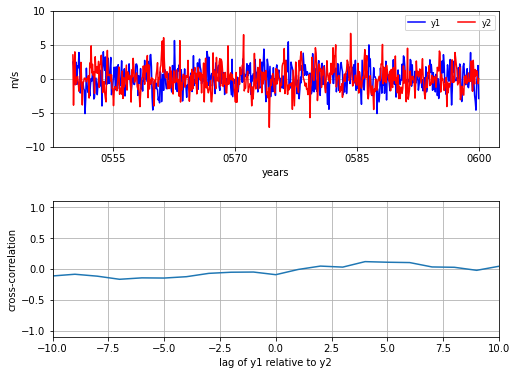

In [12]:
x = wnpm_anom.time
y1 = wnpm_anom.values
y2 = ausm_anom.values

npts = len(y1)
lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (npts * y1.std() * y2.std())

fig, axs = plt.subplots(figsize=(8, 6), nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='y1')
ax.plot(x, y2, 'r', label='y2')
ax.set_ylabel('m/s')
ax.set_xlabel('years')
ax.set_ylim(-10, 10)
ax.grid()
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')
ax.set_xlim([-10, 10])  # Corrected line
ax.set_ylim(-1.1, 1.1)
ax.grid()
maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)

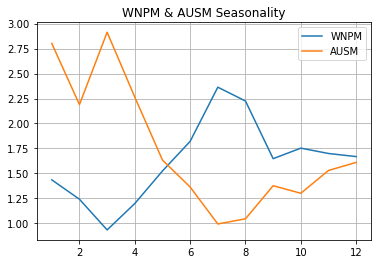

In [13]:
y1_clim = wnpm_anom.groupby("time.month").std(dim="time")
y2_clim = ausm_anom.groupby("time.month").std(dim="time")
plt.plot(y1_clim.month, y1_clim, label='WNPM')
plt.plot(y2_clim.month, y2_clim, label='AUSM')
plt.title('WNPM & AUSM Seasonality')
plt.grid()
plt.legend()

### Prepare the 2D data

In [5]:
'''
Dealting with 2D data (vertical meridional)
'''
pr = pr_ds['pr'] * 86400
um = u_ds.sel(plev=slice(100000, 20000)).sel(lon=slice(100, 130), lat=slice(-45, 45)).mean(dim=('lon'))
vm = v_ds.sel(plev=slice(100000, 20000)).sel(lon=slice(100, 130), lat=slice(-45, 45)).mean(dim=('lon'))
wm = w_ds.sel(plev=slice(100000, 20000)).sel(lon=slice(100, 130), lat=slice(-45, 45)).mean(dim=('lon'))

uz = u_ds.sel(plev=slice(100000, 20000)).sel(lon=slice(100, 260), lat=slice(-5, 5)).mean(dim=('lat'))
vz = v_ds.sel(plev=slice(100000, 20000)).sel(lon=slice(100, 260), lat=slice(-5, 5)).mean(dim=('lat'))
wz = w_ds.sel(plev=slice(100000, 20000)).sel(lon=slice(100, 260), lat=slice(-5, 5)).mean(dim=('lat'))

u850 = u_ds.sel(plev=85000, lon=slice(100, 260), lat=slice(-45, 45))
v850 = v_ds.sel(plev=85000, lon=slice(100, 260), lat=slice(-45, 45))

ts = t_ds.sel(lon=slice(100, 260), lat=slice(-45, 45))


In [6]:
'''
https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20calculate%20and%20plot%20wind%20speed%20using%20MERRA-2%20wind%20component%20data%20using%20Python
'''
# longitude and latitude
plevs = um.plev
lats = um.lat
lons = uz.lon
# plev, lat = np.meshgrid(plevs, lats) # didn't use!!

# eastward wind m/s
U2M = um['ua'] # plev: 10lat: 73
# northward wind m/s
V2M = vm['va']
# upward wind m/s
W2M = wm['wap'] # plev: 10lat: 72

V2Z = vz['va']
U2Z = uz['ua'] # plev: 10lon: 75
W2Z = wz['wap'] # plev: 10lon: 74

U850 = u850['ua']
V850 = v850['va']

TS = ts['ts']

#W2M

In [7]:
'''
2D regriding !!!
'''
# Read in grid information
lon_w = W2Z['lon']
lat_w = W2M['lat']
lev_w = W2M['plev']

lon_uv = V2Z['lon'] # reference grid
lat_uv = V2M['lat'] # reference grid
lev_uv = V2M['plev'] # reference grid# Interpolate the data to the new coordinates

W2M_new = W2M.interp( # plev: 10lat: 73
    plev=lev_uv,
    lat=lat_uv,
    method='linear',
)

W2Z_new = W2Z.interp( # plev: 10lon: 75
    plev=lev_uv,
    lon=lon_uv,
    method='linear',
)

PR_new = pr.interp(
    lat=lat_uv,
    lon=lon_uv,
    method='linear',
)

TS_new = TS.interp(
    lat=lat_uv,
    lon=lon_uv,
    method='linear',
)

#W2Z_new

In [8]:
'''
calculate the anomaly
'''
dw2m = detrend_dim(calculate_anom(W2M_new), 'time', 1)
du2m = detrend_dim(calculate_anom(U2M), 'time', 1)
dv2m = detrend_dim(calculate_anom(V2M), 'time', 1)

dw2z = detrend_dim(calculate_anom(W2Z_new), 'time', 1)
du2z = detrend_dim(calculate_anom(U2Z), 'time', 1)
dv2z = detrend_dim(calculate_anom(V2Z), 'time', 1)

dpr = detrend_dim(calculate_anom(PR_new), 'time', 1)
du850 = detrend_dim(calculate_anom(U850), 'time', 1)
dv850 = detrend_dim(calculate_anom(V850), 'time', 1)

dTS = detrend_dim(calculate_anom(TS_new), 'time', 1)


### Calculate the lead and lag to Aus MI

(73, 85)


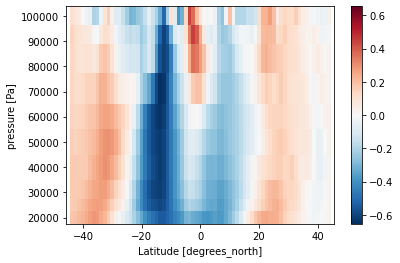

In [12]:
# simultaneous
vIndex = ausm_anom
corwm0 = xr.corr(vIndex, dw2m, dim="time")
corum0 = xr.corr(vIndex, du2m, dim="time")
corvm0 = xr.corr(vIndex, dv2m, dim="time")
regwm0 = xr.cov(vIndex, dw2m, dim="time")/vIndex.var(dim='time',skipna=True).values
regvm0 = xr.cov(vIndex, dv2m, dim="time")/vIndex.var(dim='time',skipna=True).values

corwz0 = xr.corr(vIndex, dw2z, dim="time")
coruz0 = xr.corr(vIndex, du2z, dim="time")
corvz0 = xr.corr(vIndex, dv2z, dim="time")
regwz0 = xr.cov(vIndex, dw2z, dim="time")/vIndex.var(dim='time',skipna=True).values
regvz0 = xr.cov(vIndex, dv2z, dim="time")/vIndex.var(dim='time',skipna=True).values

corpr0 = xr.corr(vIndex, dpr, dim="time")
coru0 = xr.corr(vIndex, du850, dim="time")
corv0 = xr.corr(vIndex, dv850, dim="time")

cort0 = xr.corr(vIndex, dTS, dim="time")

print(cort0.shape)
corwm0.plot()

### Plot global Vertical U speed

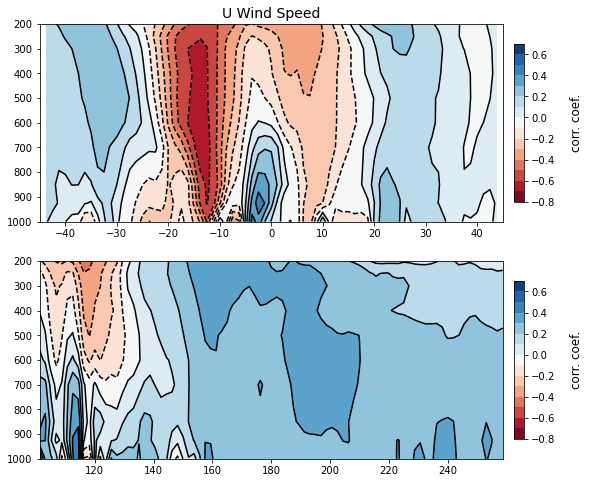

In [61]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(10, 8))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.8, 0.8, 0.1)

plt.subplot(211)
plt.contourf(lats, plevs / 100, corwm0, clevs, cmap='RdBu')
plt.title('U Wind Speed', size=14)
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)
# Change the contour color to black
plt.contour(lats, plevs / 100, corwm0, clevs, colors='black')

plt.subplot(212)
plt.contourf(lons, plevs / 100, corwz0, clevs, cmap='RdBu')
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)
plt.contour(lons, plevs / 100, corwz0, clevs, colors='black')


### Plot wind speed with direction Meridonal

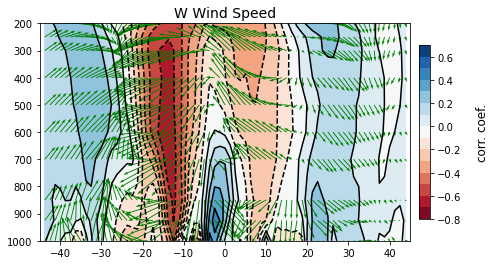

In [49]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8, 4))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.8, 0.8, 0.1)
plt.contourf(lats, plevs / 100, corwm0, clevs, cmap='RdBu')
plt.title('W Wind Speed', size=14)
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)

cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lats, plevs / 100, corwm0, clevs, colors='black')

# Overlay wind vectors
qv = plt.quiver(lats, plevs/100, corwm0, corvm0, color='green', linewidth=2, scale=5)

### Plot wind speed with direction Zonal

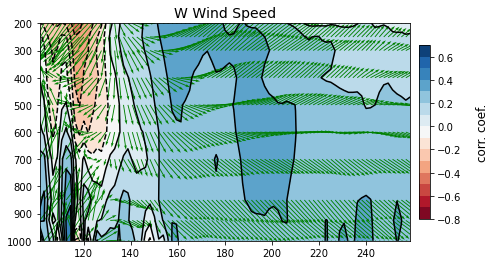

In [50]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8, 4))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.8, 0.8, 0.1)
plt.contourf(lons, plevs / 100, corwz0, clevs, cmap='RdBu')
plt.title('W Wind Speed', size=14)
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)

cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lons, plevs / 100, corwz0, clevs, colors='black')

# Overlay wind vectors
qv = plt.quiver(lons, plevs/100, corwz0, coruz0, color='green', linewidth=2, scale=5)

### Plot wind speed with direction horizonal

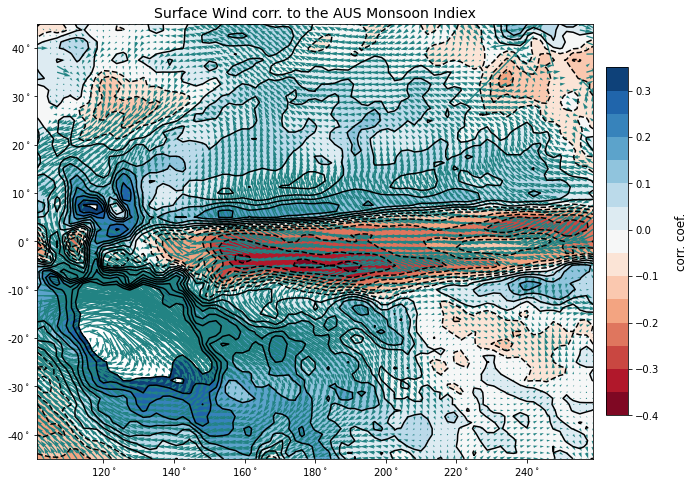

In [51]:
# Set the figure size, projection, and extent
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12, 8))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.4, 0.4, 0.05)
plt.contourf(lons, lats, corpr0, clevs, cmap='RdBu')
plt.title('Surface Wind corr. to the AUS Monsoon Indiex', size=14)
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lons, lats, corpr0, clevs, colors='black')

# Add degree symbols to x and y axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))

# Overlay wind vectors
qv = plt.quiver(lons, lats, coru0, corv0, color='#228383', linewidth=10, scale=8)


### Plot wind speed with TS

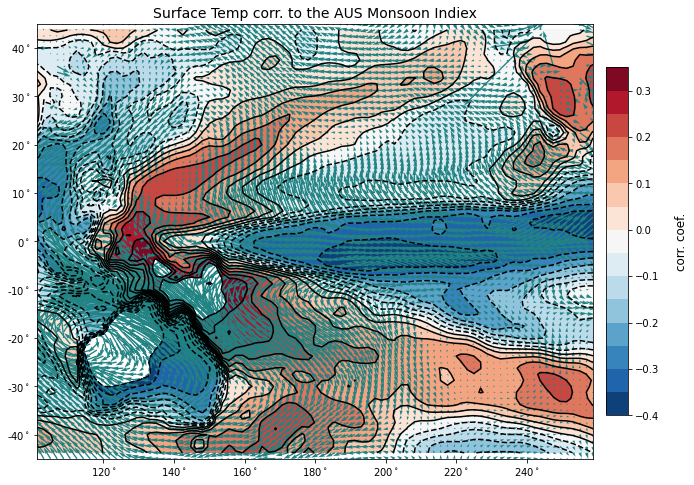

In [13]:
# Set the figure size, projection, and extent
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12, 8))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.4, 0.4, 0.05)
plt.contourf(lons, lats, cort0, clevs, cmap='RdBu_r')
plt.title('Surface Temp corr. to the AUS Monsoon Indiex', size=14)
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lons, lats, cort0, clevs, colors='black')

# Add degree symbols to x and y axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))

# Overlay wind vectors
qv = plt.quiver(lons, lats, coru0, corv0, color='#228383', linewidth=10, scale=8)


### Calculate the lead and lag to WP MI

In [14]:
# simultaneous
vIndex = wnpm_anom
corpr0 = xr.corr(vIndex, dpr, dim="time")
coru0 = xr.corr(vIndex, du850, dim="time")
corv0 = xr.corr(vIndex, dv850, dim="time")
cort0 = xr.corr(vIndex, dTS, dim="time")

corwm0 = xr.corr(vIndex, dw2m, dim="time")
corwz0 = xr.corr(vIndex, dw2z, dim="time")

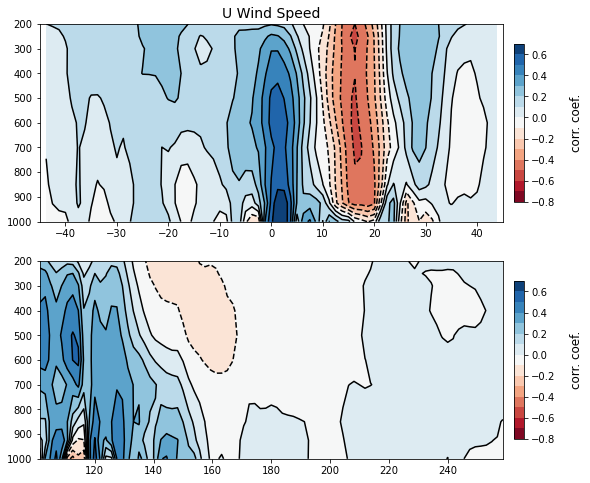

In [59]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(10, 8))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.8, 0.8, 0.1)

plt.subplot(211)
plt.contourf(lats, plevs / 100, corwm0, clevs, cmap='RdBu')
plt.title('U Wind Speed', size=14)
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)

cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lats, plevs / 100, corwm0, clevs, colors='black')


plt.subplot(212)
plt.contourf(lons, plevs / 100, corwz0, clevs, cmap='RdBu')
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)
plt.contour(lons, plevs / 100, corwz0, clevs, colors='black')


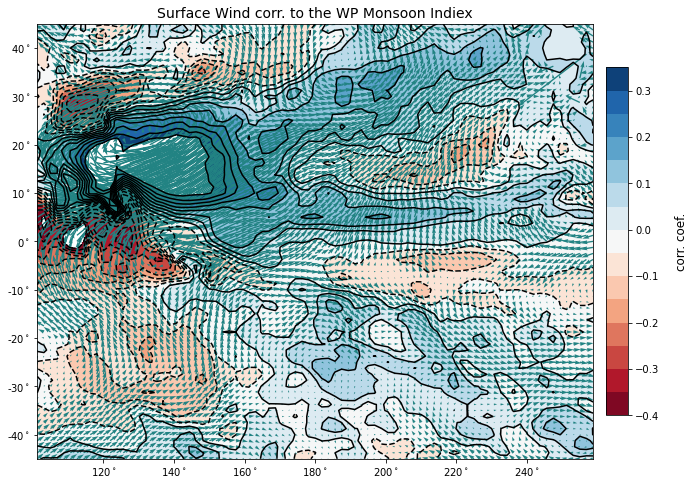

In [54]:
# Set the figure size, projection, and extent
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12, 8))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.4, 0.4, 0.05)
plt.contourf(lons, lats, corpr0, clevs, cmap='RdBu')
plt.title('Surface Wind corr. to the WP Monsoon Indiex', size=14)
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lons, lats, corpr0, clevs, colors='black')

# Add degree symbols to x and y axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))

# Overlay wind vectors
qv = plt.quiver(lons, lats, coru0, corv0, color='#228383', linewidth=10, scale=8)


** Note
* experience of RP2!!

1. The interannual modulated siginal on Aus Monsoon is closer to the ENSO, Walker circulation.
2. From the Hadley circulation, the Aus Monsoon is more global pattern.
3. On the other hand, the WP Monsoon is linked to the PMM mode, according to the wind and SSTa patterns.
4. From the Hadley circulation, the WP Monsoon is more focus at the Northern Pacific!!

### Plot wind speed with TS

In [ ]:
# Set the figure size, projection, and extent
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12, 8))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.4, 0.4, 0.05)
plt.contourf(lons, lats, cort0, clevs, cmap='RdBu_r')
plt.title('Surface Temp corr. to the WP Monsoon Indiex', size=14)
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)
cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lons, lats, cort0, clevs, colors='black')

# Add degree symbols to x and y axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$^\circ$"))

# Overlay wind vectors
qv = plt.quiver(lons, lats, coru0, corv0, color='#228383', linewidth=10, scale=8)


# check vertical cloud (working on)

In [42]:
'''
cloud
'''

idir = '/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/'
cl1Name = 'r1i1p2f1/Amon/cl/gn/v20230616/cl_Amon_ACCESS-CM2_piControl_r1i1p2f1_gn_050001-051912.nc'

# Open a netCDF data file using xarray default engine and load the data into xarrays
cl_in = xr.open_dataset(idir+cl1Name)

# Use date as the dimension rather than time
year_start = 550
year_end = 599

cl_ds = pr_in.sel(time=slice(f'{year_start:04d}', f'{year_end:04d}')) # 192 x 144


In [27]:
'''
calculate the anomaly
'''
# simultaneous
vIndex = ausm_anom

dw2m = detrend_dim(calculate_anom(W2M_new), 'time', 1)
corwm0 = xr.corr(vIndex, dw2m, dim="time")


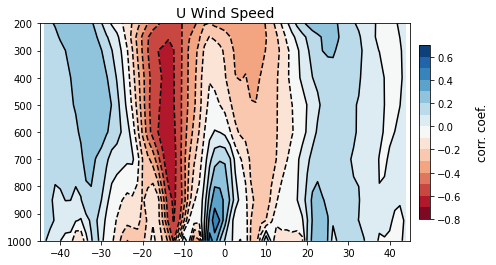

In [ ]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8, 4))

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(-0.8, 0.8, 0.1)
plt.contourf(lats, plevs / 100, corwm0, clevs, cmap='RdBu')
plt.title('U Wind Speed', size=14)
plt.gca().invert_yaxis()  # Reverse the y-axis
cb = plt.colorbar(orientation="vertical", pad=0.02, aspect=16, shrink=0.8)

# Change the label rotation to 90 degrees
cb.set_label('corr. coef.', size=12, rotation=90, labelpad=15)

cb.ax.tick_params(labelsize=10)

# Change the contour color to black
plt.contour(lats, plevs / 100, corwm0, clevs, colors='black')
